In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale, MinMaxScaler
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
import clean_functions as cf
from matplotlib.lines import Line2D
import math
from PIL import Image
plt.style.use('seaborn-v0_8-dark')

current_dir = Path.cwd()
parent_dir = current_dir.parent 

c:\Users\cflor\PycharmProjects\MetcalfProject\backend\app\Scripts


## 00_parameters.R

In [2]:
#Loading Data
Cal30 = pd.read_csv(f"{parent_dir}/data/calenviroscreen-3.0-results-june-2018-update.csv")
Cal40 = pd.read_csv(f"{parent_dir}/data/calenviroscreen40resultsdatadictionary_F_2021.csv")
cci_22 = pd.read_csv(f"{parent_dir}/data/cci_2022myu_detaileddata.csv", dtype=str)
tract_designations = pd.read_csv(f"{parent_dir}/data/ab1550censustracts_ces3_2021 - All Census Tracts.csv")
cdc_df = pd.read_csv(f"{parent_dir}/data/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2020_release.csv")
cci_24 = pd.read_csv(f"{parent_dir}/data/cci_2024ar_detaileddata.csv")

#CalEnviroScreen variable names
env_exp_vars = ["Ozone","PM2.5","Diesel PM","Drinking Water","Lead","Pesticides","Tox. Release","Traffic"]
env_eff_vars = ['Cleanup Sites','Groundwater Threats','Haz. Waste','Imp. Water Bodies','Solid Waste']
ses_vars = ['Education','Linguistic Isolation','Poverty','Unemployment','Housing Burden']
#Sensitive population variables
pop_vars = ["Asthma", "Low Birth Weight", "Cardiovascular Disease"]

all_vars = env_exp_vars + env_eff_vars + pop_vars + ses_vars
print(all_vars)

#DAC Calculations
numTracts = 7932

#Climate Investment Fund Categories
community_dev_cars = ["Urban Greening Program",
                      "Low Carbon Economy Workforce",
                      "Training and Workforce Development Program",
                      "Urban and Community Forestry Program",
                      "Affordable Housing and Sustainable Communities",
                      "Low-Income Weatherization Program",
                      "Transformative Climate Communities"]
air_pollution_vars = ["Community Air Grants",
                      "Commnunity Air Grants",
                      "Community Air Protection Funds",
                      "Woodsmoke Reduction Program",
                      "Low Carbon Transportation"]
transportation_vars = ["Technical Assistance",
                        "Transit and Intercity Rail Capital Program",
                        "Low Carbon Transit Operations Program"]
agriculture_vars = ["Renewable Energy for Agriculture Program",
                     "Funding Agricultural Replacement Measures for Emission Reductions",
                     "Food Production Investment Program",
                     "Low Carbon Fuels Production",
                     "Climate Smart Agriculture"]
adaptation_infrastructure_vars = ["Coastal Resilience Planning",
                                  "Climate Ready Program",
                                  "Forest Carbon Plan Implementation",
                                  "Climate Adaptation and Resiliency Program",
                                  "Fire Prevention Program",
                                  "Wetlands and Watershed Program",
                                  "Forest Health Program"]
utilities_vars = ["Safe and Affordable Funding for Equity and Resilience (Drinking Water)",
                   "Water-Energy Efficiency",
                   "Waste Diversion Program"]

['Ozone', 'PM2.5', 'Diesel PM', 'Drinking Water', 'Lead', 'Pesticides', 'Tox. Release', 'Traffic', 'Cleanup Sites', 'Groundwater Threats', 'Haz. Waste', 'Imp. Water Bodies', 'Solid Waste', 'Asthma', 'Low Birth Weight', 'Cardiovascular Disease', 'Education', 'Linguistic Isolation', 'Poverty', 'Unemployment', 'Housing Burden']


C:\Users\cflor\AppData\Local\Temp\ipykernel_50244\2900602904.py:7: DtypeWarning: Columns (1,7,8,11,12,13,14,18,22,26,50,63,107,109,113,114,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  cci_24 = pd.read_csv(f"{parent_dir}/data/cci_2024ar_detaileddata.csv")


## 00_process_funding.R + Other Functions

In [3]:
def allocate_resources(money, pot):
    # Sort individuals by their total amount of money, then by their initial amount of money
    allocation_order = sort(money)
    
    # Calculate amount of money to next highest value
    money_diff = money[allocation_order][1:] - money[allocation_order][:-1]
    
    # Remove excess money, starting with individuals who have the largest total amount of money
    remaining_pot = pot
    allocated_money = np.zeros(len(money))

    for i in range(len(money)):
        if i < len(money) - 1:
            # Calculate the maximum amount of money that can be allocated to the individual without violating the constraint
            max_additional_allocation = min(remaining_pot, (i+1)*money_diff[i])
        if max_additional_allocation > 0:
            allocated_money[:i+1] += max_additional_allocation / (i+1)
            remaining_pot -= max_additional_allocation
            
    return allocated_money
   # Calculate amount of money to next highest value

def process_funding_with_tracts(tracts_only, tol=10**-3):
    tracts_only = tracts_only.loc[tracts_only['Total Program GGRFFunding'] > 0]
    return

def get_tract_changes(old_df, new_df):
    old_tracts = set(old_df.loc[old_df['DAC'] == 1]['Census Tract'].values)
    new_tracts = set(new_df.loc[new_df['DAC'] == 1]['Census Tract'].values)
    removed_tracts = old_tracts.difference(new_tracts)
    added_tracts = new_tracts.difference(old_tracts)
    total_changes = removed_tracts | added_tracts
    percent_change = round(len(total_changes) / len(old_df) * 100, 2)
    changed_counties = list(set(old_df.loc[old_df['Census Tract'].isin(list(total_changes))]['County']))
    return (removed_tracts, added_tracts, total_changes, percent_change, len(total_changes), changed_counties)
    




## Scoring Function

In [4]:
def calculate_dac_score(data, env_exp_vars_new=env_exp_vars, env_eff_vars_new=env_eff_vars, 
                        pop_vars_new=pop_vars, ses_vars_new=ses_vars,
                        omit_var=None, pop_weights_new=None, suffix=' Pctl',avg=None):
    #Remove NA values    
    data = data.dropna(subset='CES 4.0 Score')
        
    #Applying suffix
    env_exp_vars_new = [x + suffix for x in env_exp_vars_new]
    env_eff_vars_new = [x + suffix for x in env_eff_vars_new]
    ses_vars_new = [x + suffix for x in ses_vars_new]

    #Removing omitted variables
    if omit_var:
        omit_var = [x + suffix for x in omit_var]
        for var in omit_var:
            if var in env_exp_vars_new:
                env_exp_vars_new.remove(var)
            if var in env_eff_vars_new:
                env_eff_vars_new.remove(var)
            if var in ses_vars_new:
                ses_vars_new.remove(var)
            else:
                pop_vars.remove(var)
    
    #Average over components
    env_exposure = data[env_exp_vars_new].apply(np.mean, axis=1)
    env_effect = data[env_eff_vars_new].apply(np.mean, axis=1)
    ses_factors = data[ses_vars_new].apply(np.mean, axis=1)

    def weighted_mean(row, weights):
        non_na = ~np.isnan(row)
        return np.average(row[non_na], weights=weights[non_na])
        
    if pop_weights_new is None:
        if isinstance(pop_vars_new[0], list):
            pop_weights_new = [np.ones(len(group)) / len(group) for group in pop_vars_new]
        else:
            pop_weights_new = np.ones(len(pop_vars_new)) / len(pop_vars_new)
    
    if not isinstance(pop_vars_new[0], list):
        sens_pop = data[[var + suffix for var in pop_vars_new]].apply(
            lambda row: weighted_mean(row, weights=pop_weights_new), axis=1)
    else:
        sens_pop_matrix = np.zeros((len(data), len(pop_vars_new)))
        for i in range(len(pop_vars_new)):
            group_avg = data[[var + suffix for var in pop_vars_new[i]]].apply(lambda row: weighted_mean(row, weights=pop_weights_new[i]), axis=1)
            sens_pop_matrix[:, i] = group_avg
        sens_pop = np.nanmean(sens_pop_matrix, axis=1)
        
    score_df = pd.DataFrame({
        'Census Tract': data['Census Tract'],
        'County': data['County'],
        'env_exposure': env_exposure,
        'env_effect': env_effect,
        'sens_pop': sens_pop,
        'ses_factors': ses_factors
    })
    
    score_df['Pollution Burden'] = score_df[['env_exposure', 'env_effect']].apply(lambda row: np.average(row, weights=[1, 0.5]), axis=1)
    score_df['Pop Char'] = score_df[['sens_pop', 'ses_factors']].apply(np.mean, axis=1)
    
    max_pollution_burden = max(score_df['Pollution Burden'])
    max_pop_char = max(score_df['Pop Char'])
    
    #Rescaling 
    if len(score_df.loc[score_df['Pollution Burden'] < 0].values) > 0 or len(score_df.loc[score_df['Pop Char'] < 0].values) > 0:
        scaler = MinMaxScaler(feature_range=(0,10))
        score_df['Pollution Burden MinMax'] = scaler.fit_transform(score_df['Pollution Burden'].values.reshape(-1, 1))
        score_df['Pop Char MinMax'] = scaler.fit_transform(score_df['Pop Char'].values.reshape(-1, 1))
    else:
        score_df['Pollution Burden MinMax'] = 10*score_df['Pollution Burden'] / max_pollution_burden
        score_df['Pop Char MinMax'] = 10*score_df['Pop Char'] / max_pop_char
    
    if avg:
        score_df["Score"] = score_df[['Pollution Burden MinMax', 'Pop Char MinMax']].apply(np.mean, axis=1)
    else:
        score_df['Score'] = score_df['Pollution Burden MinMax'] * score_df['Pop Char MinMax']
        
    score_df['Percentile'] = score_df['Score'].rank(pct=True)*100
    
    def designate(x):
        if x > 75:
            return 1 
        else:
            return 0
            
    score_df['DAC'] = score_df['Percentile'].apply(designate)
    return score_df


## Health Outcome Comaprison

In [5]:
cdc_measures = {'CDC_Cancer': 'Cancer (excluding skin cancer) among adults aged >=18 years',
                'CDC_COPD': 'Chronic obstructive pulmonary disease among adults aged >=18 years',
                'CDC_Smoking': 'Current smoking among adults aged >=18 years',
                'CDC_Asthma': 'Current asthma among adults aged >=18 years',
                'CDC_CKD': 'Chronic kidney disease among adults aged >=18 years',
                'CDC_CVD': 'Coronary heart disease among adults aged >=18 years'}
cdc_df = cdc_df.loc[cdc_df['StateAbbr'] == 'CA']

#Initializing
measures_df = pd.DataFrame({"Census Tract": cdc_df.groupby('LocationName').count().index})

#Associting tracts with corresponding counties
counties = []

for tract in measures_df['Census Tract']:
    counties.append(cdc_df.loc[cdc_df['LocationName'] == tract]['CountyName'].values[0])
measures_df['County'] = counties

#Adding standardized and percentile columns of variables
for label, measure in cdc_measures.items():
    measures_df[label] = cdc_df.loc[cdc_df['Measure'] == measure]['Data_Value'].values
    measures_df[label + ' Scaled'] = scale(measures_df[label])
    measures_df[label + ' Pctl'] = measures_df[label].rank(pct=True)*100

ces_df = Cal40.merge(measures_df, how='left', on='Census Tract')


def calculate_r2(d1, d2):
    df = pd.DataFrame({'1': d1, '2': d2})
    df.dropna(inplace=True)
    r2 = pearsonr(df['1'], df['2'])[0]**2
    return r2

raw_r2 = [calculate_r2(ces_df['Asthma'].values, ces_df['CDC_Asthma']), 
         calculate_r2(ces_df['Cardiovascular Disease'], ces_df['CDC_CVD'])]
perc_r2 = [calculate_r2(ces_df['Asthma Pctl'], ces_df['CDC_Asthma Pctl']), 
         calculate_r2(ces_df['Cardiovascular Disease Pctl'], ces_df['CDC_CVD Pctl'])]
health_correlation = pd.DataFrame({'Measure': ['Asthma', 'Cardiovascular Disease'],
                                  'raw_r2': raw_r2,
                                  'perc_r2': perc_r2})
health_correlation

,Measure,raw_r2,perc_r2
0,Asthma,0.293398,0.299766
1,Cardiovascular Disease,0.051994,0.060744


## Standardization Comparison

In [6]:
##NOTE: The precentage of tracts that changed from switching to averaging calculates here (1.39) is 0.02% different from the paper (1.41)

ces_df2 = ces_df.copy()

#Adding Standardized columns (0 mean 1 sd)
for var in all_vars:
    ces_df2[var + ' Scaled'] = scale(ces_df[var])

new_score_df = calculate_dac_score(ces_df2)
scaled_score_df = calculate_dac_score(ces_df2, suffix=' Scaled')
avg_score_df = calculate_dac_score(ces_df2, avg=True)

print('The percentage of tracts that change designation from switching to z-score standardization is', 
      get_tract_changes(new_score_df, scaled_score_df)[3])
print('The percentage of tracts that change designation from switching to averaging is', 
      get_tract_changes(new_score_df, avg_score_df)[3])

#Can add the rest of 03_standardization_comparision (the stuff about comparing the standard deviations between precentiles)

The percentage of tracts that change designation from switching to z-score standardization is 5.35
The percentage of tracts that change designation from switching to averaging is 1.39


## Mapping Files and Functions

## Funding Functions and Variables

In [7]:
## Finding the toal number of DAC funding allocated to a subset of tracts (CCI_2022)
fund_df = pd.read_csv(f'{parent_dir}/cleaned_data/cci_2024.csv')
def make_barplot(fund_df, selected_tracts):
    fund_df = fund_df.loc[fund_df['Census Tract'].isin(selected_tracts)]
    rel_data = fund_df[['Year', 'DAC1550Amount']].groupby('Year').sum()
    year_labels = ['2019','2020','2022','2023']
    bar_colors = ['green', 'green', 'green', 'green']
    funds = rel_data.iloc[0:4]['DAC1550Amount'].values / 10**6
    plt.bar(year_labels, funds, color=bar_colors)
    plt.title('Estimated Amount of DAC Funding Reallocated (2019-2023)')
    plt.ylabel("Dollars (millions)")
    plt.ylim = max(funds) + 0.5
    plot_path = f"{parent_dir}/Static/funding_barplot.png"
    plt.savefig(plot_path)
    return plot_path
fund_df


,Census Tract,Program Name,DAC1550Amount,Project Completion Date,Year
0,6001404502,Low Carbon Transportation,0,07/10/2019,2019
1,6001436401,Low Carbon Transportation,0,07/10/2019,2019
2,6013355108,Low Carbon Transportation,0,07/10/2019,2019
3,6019003500,Low Carbon Transportation,2500,07/10/2019,2019
4,6019005505,Low Carbon Transportation,0,07/10/2019,2019
...,...,...,...,...,...
65949,6075020800,Low-Income Weatherization Program,0,06/30/2022,2022
65950,6079011103,Low-Income Weatherization Program,0,06/30/2022,2022
65951,6075016700,Low-Income Weatherization Program,0,06/30/2022,2022
65952,6065040808,Low-Income Weatherization Program,0,06/30/2022,2022


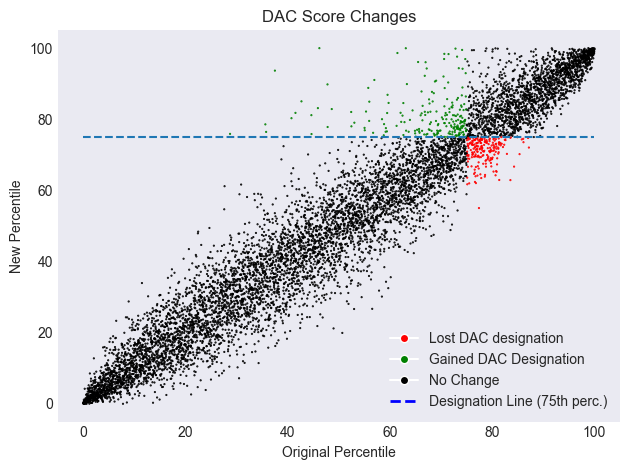

In [8]:
## Finding the toal number of DAC funding allocated to a subset of tracts (CCI_2024)
old_DAC = new_score_df.copy()
new_DAC = scaled_score_df.copy()
data_df = pd.DataFrame()
data_df['Old_Perc'] = old_DAC['Percentile']
#data_df['Old_DAC'] = old_DAC['DAC']
data_df['New_Perc'] = new_DAC['Percentile']

def get_colors(row):
    if row.iloc[0] >= 75 and row.iloc[1] < 75:
        return 'r'
    if row.iloc[0] < 75 and row.iloc[1] >= 75:
        return 'g'
    else: 
        return 'black'
    
colors = data_df.apply(get_colors, axis=1)

plt.scatter(data_df['Old_Perc'].values, data_df['New_Perc'].values, color=colors, s=0.3)
plt.plot([0,100], [75,75], ls='--')

legend_entries = [
    Line2D([0], [0], marker='o', color='w', label='Lost DAC designation', markerfacecolor='r', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Gained DAC Designation', markerfacecolor='g', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='No Change', markerfacecolor='black', markersize=6),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Designation Line (75th perc.)')
]

plt.legend(handles=legend_entries, loc='lower right')

plt.xlabel('Original Percentile')
plt.ylabel('New Percentile')
plt.title('DAC Score Changes')
plt.tight_layout()

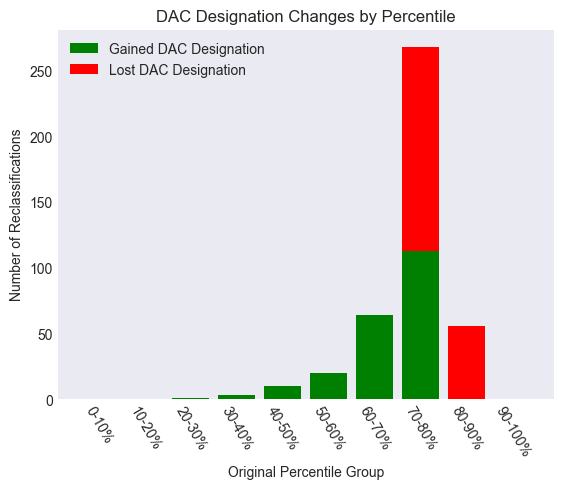

In [9]:
#Changes by Percentile
old_DAC = new_score_df.copy()
new_DAC = scaled_score_df.copy()
data_df = pd.DataFrame()
data_df['Old_Perc'] = old_DAC['Percentile']
#data_df['Old_DAC'] = old_DAC['DAC']
data_df['New_Perc'] = new_DAC['Percentile']

def gained_percentile(row):
    if row.iloc[0] < 75 and row.iloc[1] >= 75:
        return math.floor(row.iloc[0] /10)
    else: 
        return -1
    
def lost_percentile(row):
    if row.iloc[0] >= 75 and row.iloc[1] < 75:
        return math.floor(row.iloc[0] /10)
    else: 
        return -1

data_df['Gained'] = data_df.apply(gained_percentile, axis=1)
data_df['Lost'] = data_df.apply(lost_percentile, axis=1)
percentiles = np.arange(0,10)
gained_num = np.zeros(10)
lost_num = np.zeros(10)

        

num_gained = data_df.groupby('Gained').count()
num_lost = data_df.groupby('Lost').count()
#print(set(changes))
#changes = [x for x in changes if x != -1]
#changes
for x, y in zip(num_gained.index, num_gained.iloc[:,1]):
    if x in percentiles:
        gained_num[x] += y

for x, y in zip(num_lost.index, num_lost.iloc[:,1]):
    if x in percentiles:
        lost_num[x] += y

fig, ax = plt.subplots()

gain_bars = ax.bar(percentiles, gained_num, color='green', label='Gained DAC Designation')
loss_bars = ax.bar(percentiles, lost_num, bottom=gained_num, color='red', label='Lost DAC Designation')
precenetile_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

ax.set_xlabel('Original Percentile Group')
ax.set_xticks(percentiles)
ax.set_xticklabels(precenetile_labels, rotation=-60)
ax.set_ylabel('Number of Reclassifications')
ax.set_title('DAC Designation Changes by Percentile')
ax.legend()

In [10]:
from Graph_functions import funding_barplot, changes_barplot, changes_scatterplot
fund_df = pd.read_csv(f'{parent_dir}/cleaned_data/cci_2024.csv')
funding_barplot(fund_df=fund_df, selected_tracts=get_tract_changes(new_score_df, scaled_score_df)[2])


'c:\\Users\\cflor\\PycharmProjects\\MetcalfProject/Static/img/funding_barplot.png'

In [11]:
fp = f"{parent_dir}/Static/img/changes_barplot.png"

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

def calculate_aspect_ratio(width, height):
    return width / height

width, height = get_image_dimensions(fp)

aspect_ratio = calculate_aspect_ratio(width, height)
aspect_ratio

1.3333333333333333